In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Links:
* [Colah blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

# RNN intro


Давайте разберемся что из себя вообще представляют рекуррентные нейронные сети в самом простом виде.

В самом простом виде для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ -- входной вектор на текущем шаге
* $y(t)$ -- выходной вектор на текущем шаге
* $w_x$ -- вектор весов нейронов для входа
* $w_y$ -- вектор весов нейронов для выхода
* $y(t-1)$ -- выходной вектор с прошлого шага. Для шага 0 этот вектор нулевой
* $b$ -- байес (bias)
* $\phi$ -- обозначение для функции активации, например ReLU


<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

Есть понятие **hidden_state** ( $h(t)$ ) -- это "память" рекуррентной ячейки.

В общем случае $h_{(t)} = f(h_{(t-1)}, x_{(t)})$, на выход также $y{(t)} = f(h{(t-1)}, x{(t)})$.


### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в скобках квадратных -- конкатенация матриц

По размерностям:
* $Y_{(t)}$ -- матрица [$m$ x n_neurons]
* $X_{(t)}$ -- матрица [$m$ x n_features]
* $b$ -- вектор длины n_neurons
* $W_x$ -- веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ -- веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

### Задание

Напишите класс RNN реализующий vanilla RNN

In [2]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()
        # batch_size * (input_size + hidden_size)
        #              (input_size + hidden_size) * hidden_size

    def forward(self, input_data, hidden):
#         print(input_data.shape, hidden.shape)
#         print(torch.cat([input_data, hidden], 1).shape)
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)
        return hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [3]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [4]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.initHidden(batch_size)

In [5]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [6]:
print(new_hidden.shape)

torch.Size([1, 5])


In [7]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[-0.3387702   0.5761364   0.3029954  -0.08357252 -0.53223586]]


In [8]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[-0.32066664  0.46051094  0.05908853 -0.21078056 -0.5292097 ]]


### Задание

Модифицировать код так, чтобы на входе можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [9]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


Загружаем данные

In [10]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [11]:
!ls -lh data/

total 8,0K
drwxr-xr-x 3 kikos kikos 4,0K мар 23 14:22 imdb
drwxr-xr-x 4 kikos kikos 4,0K мар 23 13:57 MNIST


Populating the interactive namespace from numpy and matplotlib


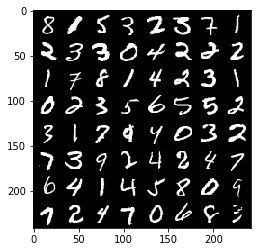

In [12]:
%pylab inline
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [13]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [14]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0068, -0.0058, -0.0950, -0.0017,  0.0833,  0.0388, -0.0059,  0.0246,
          0.0543, -0.0440],
        [-0.0041, -0.0075, -0.0972, -0.0226,  0.0854,  0.0297,  0.0025,  0.0395,
          0.0601, -0.0437],
        [ 0.0040, -0.0084, -0.0946, -0.0057,  0.0874,  0.0391, -0.0053,  0.0284,
          0.0460, -0.0454],
        [-0.0120, -0.0044, -0.0851, -0.0232,  0.0653,  0.0286,  0.0046,  0.0251,
          0.0540, -0.0221],
        [ 0.0062, -0.0094, -0.1062, -0.0136,  0.0835,  0.0391,  0.0005,  0.0279,
          0.0585, -0.0501],
        [-0.0011, -0.0033, -0.0933, -0.0075,  0.0835,  0.0357, -0.0003,  0.0235,
          0.0546, -0.0370],
        [-0.0004, -0.0083, -0.0967, -0.0218,  0.1003,  0.0448, -0.0061,  0.0225,
          0.0652, -0.0426],
        [-0.0040, -0.0065, -0.0959, -0.0167,  0.0874,  0.0349, -0.0051,  0.0255,
          0.0572, -0.0453],
        [-0.0005, -0.0099, -0.0903, -0.0164,  0.0880,  0.0408, -0.0063,  0.0180,
          0.0555, -0.0326],
        [-0.0349, -

## Обучаем

In [16]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6275 | Train Accuracy: 79.52
Epoch:  1 | Loss: 0.2995 | Train Accuracy: 90.88
Epoch:  2 | Loss: 0.2260 | Train Accuracy: 93.07
Epoch:  3 | Loss: 0.1922 | Train Accuracy: 94.04


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

# Сентимент анализ по аналогии

пишем сами с нуля

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

$~ pip install torchtext

$~ python -m spacy download en


In [ ]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

In [ ]:
ls -lh data/imdb/aclImdb/

In [ ]:
print(len(train_data))
print(len(test_data))

In [ ]:
print(vars(train_data.examples[0]))

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))

In [ ]:
vars(LABEL.vocab)

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

In [ ]:
print(LABEL.vocab.stoi)

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
import torch.optim as optim

def out(t):
    for x in t:
        print(TEXT.vocab.itos[x], end=' ')
    print()

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # можно добавить линейный слой, который делает проекцию в 2 класса
    def forward(self, text):

        #text = [sent len, batch size]
#         print(text.shape)
        text = text.permute(1, 0)
#         print(text.shape)
#         out(text[0]);
#         out(text[1]);
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        #embedded = [sent len, batch size, emb dim]
        hidden = torch.zeros(1, BATCH_SIZE, self.hidden_dim)
#         print(embedded.shape)
#         print(hidden.shape)
        output, hidden = self.rnn(embedded, hidden)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

N_EPHOCS = 25
N_WORDS = 30
N_EMBEDDED = 15
N_HIDDEN = 50
N_OUTPUT = 2
model = RNN(N_WORDS, N_EMBEDDED, N_HIDDEN, N_OUTPUT)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def get_accuracy(logit, target, batch_size):    
    corrects = np.isclose(np.argmax(logit.detach().numpy(), axis=1), target.data.detach().numpy())
#     print(corrects)
    accuracy = 100.0 * corrects.sum()/batch_size
    return accuracy.item()

In [72]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    rounds = 0
    for i, _data in enumerate(train_iterator):
        if len(_data) != BATCH_SIZE:
            continue
        rounds += 1
        text = _data.text.clone()
#         print(text.shape)
        label = _data.label
        text = text.permute(1, 0)
#         print(text.shape)
        for x in text:
            while len(x) < N_WORDS:
                x.append(1)
        text = text[:,:N_WORDS]
        text = text.permute(1, 0)
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(text)
        res_label = torch.zeros(label.shape, dtype=torch.int64)
        for i in range(len(res_label)):
            if label[i] > 0.5:
                res_label[i] = 1
        label = res_label
        
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, label, BATCH_SIZE)
        
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / rounds, train_acc/rounds))

Epoch:  0 | Loss: 0.6960 | Train Accuracy: 50.07
Epoch:  1 | Loss: 0.6924 | Train Accuracy: 52.45
Epoch:  2 | Loss: 0.6838 | Train Accuracy: 55.83
Epoch:  3 | Loss: 0.6652 | Train Accuracy: 60.40
Epoch:  4 | Loss: 0.6400 | Train Accuracy: 64.19
Epoch:  5 | Loss: 0.6151 | Train Accuracy: 67.42
Epoch:  6 | Loss: 0.5886 | Train Accuracy: 70.14
Epoch:  7 | Loss: 0.5544 | Train Accuracy: 73.16
Epoch:  8 | Loss: 0.5227 | Train Accuracy: 75.56
Epoch:  9 | Loss: 0.4928 | Train Accuracy: 77.60
Epoch:  10 | Loss: 0.4587 | Train Accuracy: 80.01
Epoch:  11 | Loss: 0.4284 | Train Accuracy: 81.99
Epoch:  12 | Loss: 0.4009 | Train Accuracy: 83.40
Epoch:  13 | Loss: 0.3752 | Train Accuracy: 84.83
Epoch:  14 | Loss: 0.3456 | Train Accuracy: 86.53
Epoch:  15 | Loss: 0.3226 | Train Accuracy: 87.61
Epoch:  16 | Loss: 0.2971 | Train Accuracy: 89.02
Epoch:  17 | Loss: 0.2763 | Train Accuracy: 89.96
Epoch:  18 | Loss: 0.2576 | Train Accuracy: 90.75
Epoch:  19 | Loss: 0.2356 | Train Accuracy: 91.74
Epoch:  20

In [73]:
model.eval()
rounds = 0
running_loss = 0.0
running_accuracy = 0.0
for _data in valid_iterator:
    if len(_data) != BATCH_SIZE:
            continue
    rounds += 1
    text = _data.text.clone()
#         print(text.shape)
    label = _data.label
    text = text.permute(1, 0)
#         print(text.shape)
    for x in text:
        while len(x) < N_WORDS:
            x.append(1)
    text = text[:,:N_WORDS]
    text = text.permute(1, 0)
     # zero the parameter gradients
    # forward + backward + optimize
    outputs = model(text)
    res_label = torch.zeros(label.shape, dtype=torch.int64)
    for i in range(len(res_label)):
        if label[i] > 0.5:
            res_label[i] = 1
    label = res_label
    loss = criterion(outputs, label)
    
    running_loss += loss.detach().item()
    running_accuracy += get_accuracy(outputs, label, BATCH_SIZE)
print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, running_loss / rounds, running_accuracy/rounds))

Epoch:  24 | Loss: 0.9945 | Train Accuracy: 68.30
